# Connectome equivalence across multiple atlas

### Set the environment

In [2]:
!pip install cmocean

  Obtaining dependency information for cmocean from https://files.pythonhosted.org/packages/c6/ba/b0875adc079876083b458c46dbc097d3316a5c9610745e610288cac70f95/cmocean-3.1.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 4.5 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Set the environment
import os
import glob
import numpy as np
import nibabel as nib
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt
import cmocean

# Add cmocean maps to cmaps variable
cmaps = cmocean.cm.cmap_d

STUDY_DIR=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA")
DERIVATIVE_DIR_DIR=os.path.join(STUDY_DIR,"bids_data","derivatives_wCorrectedFS")

# Set the working directory to the 'out' directory
out=DERIVATIVE_DIR_DIR
os.chdir(out)     # <<<<<<<<<<<< CHANGE THIS PATH

# This variable will be different for each subject
sub='TRACK-P085' # <<<<<<<<<<<< CHANGE THIS SUBJECT's ID
ses='1'    # <<<<<<<<<<<< CHANGE THIS SUBJECT's SESSION
subjectID=f'sub-{sub}_ses-{ses}'           
subjectDir=f'micapipe_v0.2.0/sub-{sub}/ses-{ses}' 

# Path to MICAPIPE from global enviroment
micapipe=os.popen("echo $MICAPIPE").read()[:-1] # <<<<<<<<<<<< CHANGE THIS PATH

# All parcelations list
parc = ['aparc-a2009s', 'aparc', 'economo', 'glasser-360',
         'schaefer-100','schaefer-200','schaefer-300','schaefer-400',
         'schaefer-500','schaefer-600','schaefer-700','schaefer-800',
         'schaefer-900','schaefer-1000','vosdewael-100','vosdewael-200',
         'vosdewael-300','vosdewael-400']


### Load the standard inflated surfaces

In [5]:
# Load fsLR-5k inflated
f5k_lh = read_surface(f'{micapipe}/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
f5k_rh = read_surface(f'{micapipe}/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# Load fsLR-32k inflated
f32k_lh = read_surface(f'{micapipe}/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
f32k_rh = read_surface(f'{micapipe}/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# Load fsaverage5 inflated
fs5_lh = read_surface(f'{micapipe}/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
fs5_rh = read_surface(f'{micapipe}/surfaces/fsaverage5/surf/rh.inflated', itype='fs')


# Parcellated matrices

| **parc**        | **GD shape** | **MPC shape** | **SC shape** | **FC shape** |
|-----------------|--------------|---------------|--------------|--------------|
| `fsLR-5k`       | 9684 x 9684  | 9684 x 9684   | 9684 x 9684  | 9684 x 9684  |
| `aparc-a2009s`  | 150 x 150    | 150 x 150     | 198 x 198    | 199 x 199    |
| `aparc`         | 72 x 72      | 72 x 72       | 120 x 120    | 119 x 119    |
| `economo`       | 88 x 88      | 88 x 88       | 136 x 136    | 135 x 135    |
| `glasser-360`   | 362 x 362    | 362 x 362     | 410 x 410    | 409 x 409    |
| `schaefer-100`  | 102 x 102    | 102 x 102     | 150 x 150    | 149 x 149    |
| `schaefer-200`  | 202 x 202    | 202 x 202     | 250 x 250    | 249 x 249    |
| `schaefer-300`  | 302 x 302    | 302 x 302     | 350 x 350    | 349 x 349    |
| `schaefer-400`  | 402 x 402    | 402 x 402     | 450 x 450    | 449 x 449    |
| `schaefer-500`  | 502 x 502    | 502 x 502     | 550 x 550    | 549 x 549    |
| `schaefer-600`  | 602 x 602    | 602 x 602     | 650 x 650    | 649 x 649    |
| `schaefer-700`  | 702 x 702    | 702 x 702     | 750 x 750    | 749 x 749    |
| `schaefer-800`  | 802 x 802    | 802 x 802     | 850 x 850    | 849 x 849    |
| `schaefer-900`  | 902 x 902    | 902 x 902     | 950 x 950    | 949 x 949    |
| `schaefer-1000` | 1002 x 1002  | 1002 x 1002   | 1050 x 1050  | 1048 x 1048  |
| `vosdewael-100` | 102 x 102    | 102 x 102     | 150 x 150    | 149 x 149    |
| `vosdewael-200` | 202 x 202    | 202 x 202     | 250 x 250    | 249 x 249    |
| `vosdewael-300` | 302 x 302    | 302 x 302     | 350 x 350    | 349 x 349    |
| `vosdewael-400` | 402 x 402    | 402 x 402     | 450 x 450    | 449 x 449    |

> For `GD` and `MPC` their indices correspond only to cortical regions. In both matrices the midwall indices is 0.

In [6]:
def load_annot(atlas, surf='fsaverage5'):
    '''
    Script that loads the labels of an specific parcellation and generates a midwall mask
    '''
    
    # Load LEFT annotation file in fsaverage5
    annot_lh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/lh.{atlas}_mics.annot')

    # Unique number of labels of a given atlas
    Ndim = max(np.unique(annot_lh_fs5[0]))
    
    if surf == 'fsaverage5':

        # Load RIGHT annotation file in fsaverage5
        annot_rh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/rh.{atlas}_mics.annot')[0]+Ndim

        # replace with 0 the medial wall of the right labels
        annot_rh_fs5 = np.where(annot_rh_fs5==Ndim, 0, annot_rh_fs5) 

        # fsaverage5 labels
        labels = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)
    
    else:
        # Read label for fsLR-32k
        labels = np.loadtxt(open(f'{micapipe}/parcellations/{atlas}_conte69.csv'), dtype=int)

    # mask of the medial wall
    mask = labels != 0
    
    # Midwall labels of aparc-a2009s are lh=42 and rh=117
    if atlas == 'aparc-a2009s' and surf == 'fsaverage5':
        mask[(labels == 117) | (labels == 42)] = 0
    
    #print(f'{atlas}; midwall = {Ndim}, length = {str(labels.shape)}')
    
    return(labels, mask, Ndim)


In [28]:
parc

['aparc-a2009s',
 'aparc',
 'economo',
 'glasser-360',
 'schaefer-100',
 'schaefer-200',
 'schaefer-300',
 'schaefer-400',
 'schaefer-500',
 'schaefer-600',
 'schaefer-700',
 'schaefer-800',
 'schaefer-900',
 'schaefer-1000',
 'vosdewael-100',
 'vosdewael-200',
 'vosdewael-300',
 'vosdewael-400']

In [29]:
# Empty list of surface plots
surf_fs5 = [None] * len(parc)
surf_32k = [None] * len(parc)

# Iterate over each parcellation to create a list of surface plots
for i, g in enumerate(parc):
    
    # Load fsaverage5 labels
    labels_fs5, mask_fs5, _ = load_annot(g, surf='fsaverage5')
    # Load fsLR-32k labels
    labels_32k, mask_32k, _ = load_annot(g, surf='fsLR-32k')

    # Map labels to surface fsaverage5
    surf_fs5[i] = map_to_labels(np.unique(labels_fs5.astype(float)), labels_fs5,  fill=np.nan, mask=mask_fs5)
    # Map labels to surface fsLR-32k
    surf_32k[i] = map_to_labels(np.unique(labels_fs5.astype(float)), labels_32k,  fill=np.nan, mask=mask_32k)


In [30]:
surf_32k

[array([ 72.,   3.,  29., ..., 113., 113., 113.]),
 array([ 9., 21., 23., ..., 49., 49., 49.]),
 array([21., 32.,  0., ..., 85., 85., 85.]),
 array([ 34.,  51.,  11., ..., 312., 312., 312.]),
 array([49., 20., 12., ..., 90., 90., 90.]),
 array([ 96.,  39.,  20., ..., 167., 167., 167.]),
 array([147.,  50.,  35., ..., 250., 250., 250.]),
 array([195.,  66.,  46., ..., 338., 338., 338.]),
 array([243.,  81.,  60., ..., 464., 464., 464.]),
 array([289.,  97.,  71., ..., 506., 506., 506.]),
 array([274.,  73.,  89., ..., 598., 600., 600.]),
 array([380., 132.,  98., ..., 680., 680., 680.]),
 array([365.,  96., 110., ..., 767., 767., 767.]),
 array([478., 169., 123., ..., 936., 936., 860.]),
 array([ 6., 48., 22., ..., 58., 58., 58.]),
 array([  3.,  92.,  61., ..., 114., 114., 114.]),
 array([ 54.,  42.,  17., ..., 220., 220., 220.]),
 array([100.,   9., 103., ..., 370., 370., 370.])]

## Anatomy based parcellations 

### Desikan-Killiany (aka Freesurfer aparc)
> Desikan, R. S., Ségonne, F., Fischl, B., Quinn, B. T., Dickerson, B. C., Blacker, D., ... & Albert, M. S. (2006). An automated labeling system for subdividing the human cerebral cortex on MRI scans into gyral based regions of interest. Neuroimage, 31(3), 968-980.

### Dextrieux (aka Freesurfer aparc-a2009s)
> Destrieux, C., Fischl, B., Dale, A., & Halgren, E. (2010). Automatic parcellation of human cortical gyri and sulci using standard anatomical nomenclature. Neuroimage, 53(1), 1-15.


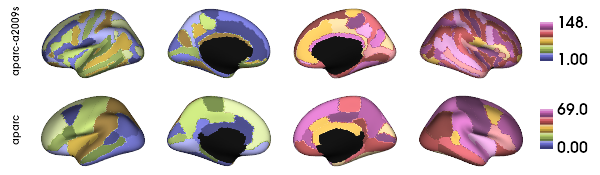

In [8]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=surf_fs5[0:2], size=(600, 175), cmap='tab20b',
                 embed_nb=True, label_text={'left':parc[0:2]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

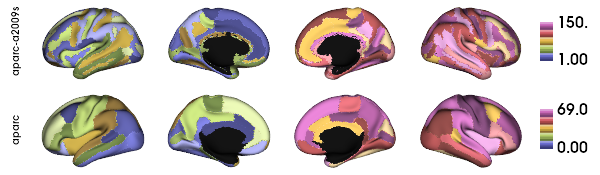

In [9]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=surf_32k[0:2], size=(600, 175), cmap='tab20b',
                 embed_nb=True, label_text={'left':parc[0:2]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

## Histology based parcellation


### Economo-Koskinas
> Scholtens, L. H., de Reus, M. A., de Lange, S. C., Schmidt, R., & van den Heuvel, M. P. (2018). An mri von economo–koskinas atlas. NeuroImage, 170, 249-256.


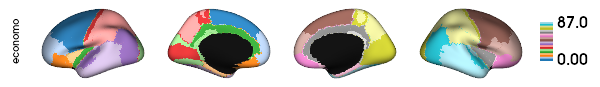

In [10]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=surf_fs5[2], size=(600, 87), cmap='tab20',
                 embed_nb=True, label_text={'left':[parc[2]]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

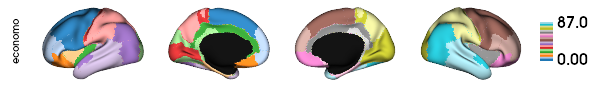

In [11]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=surf_32k[2], size=(600, 87), cmap='tab20',
                 embed_nb=True, label_text={'left':[parc[2]]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

## Multimodal based parcellation

### Glasser
> Glasser, M. F., Coalson, T. S., Robinson, E. C., Hacker, C. D., Harwell, J., Yacoub, E., ... & Smith, S. M. (2016). A multi-modal parcellation of human cerebral cortex. Nature, 536(7615), 171-178.


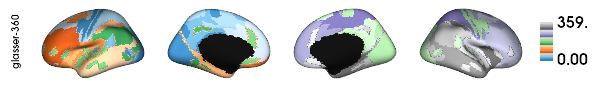

In [12]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=surf_fs5[3], size=(600, 87), cmap='tab20c',
                 embed_nb=True, label_text={'left':[parc[3]]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

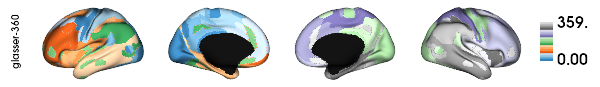

In [13]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=surf_32k[3], size=(600, 87), cmap='tab20c',
                 embed_nb=True, label_text={'left':[parc[3]]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

## Functional based parcellation

### Schaefer 100-1000
> Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., ... & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. Cerebral cortex, 28(9), 3095-3114.


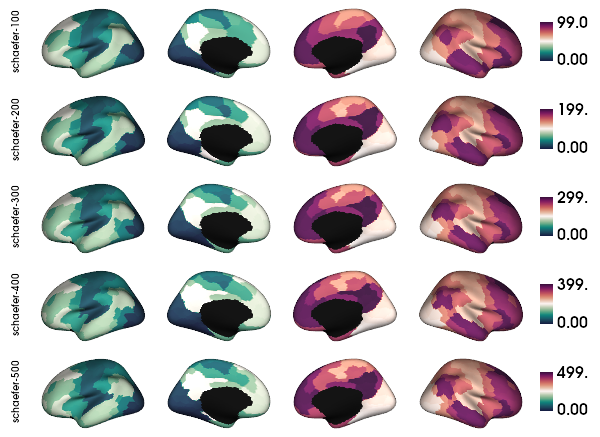

In [14]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=surf_fs5[4:9], size=(600, 437), cmap='cmo.curl',
                 embed_nb=True, label_text={'left':parc[4:9]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

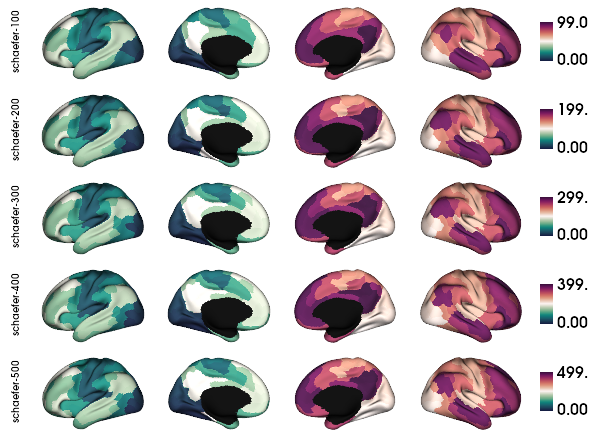

In [15]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=surf_32k[4:9], size=(600, 437), cmap='cmo.curl',
                 embed_nb=True, label_text={'left':parc[4:9]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

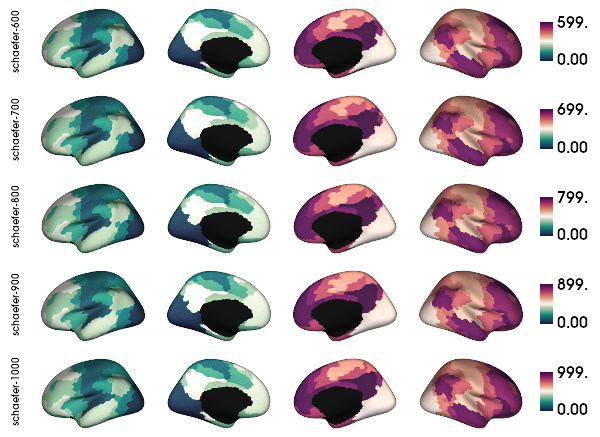

In [16]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=surf_fs5[9:14], size=(600, 437), cmap='cmo.curl',
                 embed_nb=True, label_text={'left':parc[9:14]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

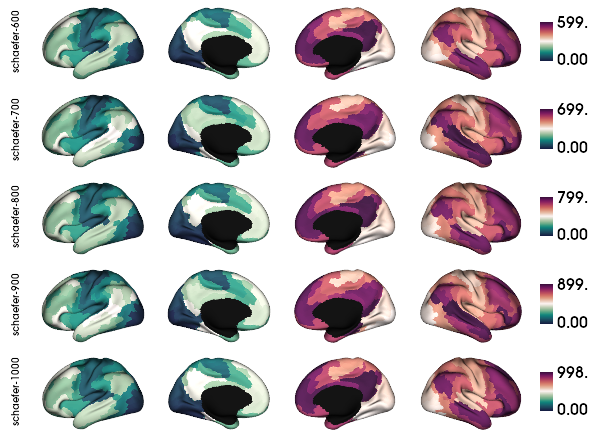

In [17]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=surf_32k[9:14], size=(600, 437), cmap='cmo.curl',
                 embed_nb=True, label_text={'left':parc[9:14]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

## Random parcellation based on `Desikan Killiany`

### Vosdevael 100-500
vosdewael parcellations are semi-random subparcellations of Desikan Killiany, obtained by spliting in two the bigest parcel iterativelly until the desired number of parcels is reached.


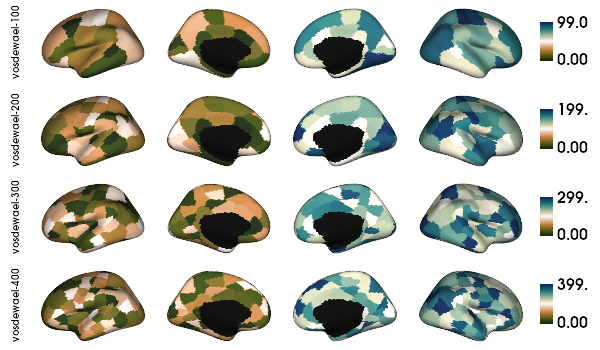

In [18]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=surf_fs5[14:18], size=(600, 350), cmap='cmo.tarn',
                 embed_nb=True, label_text={'left':parc[14:18]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

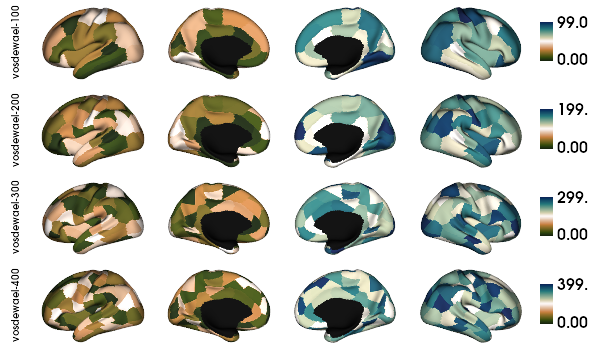

In [19]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=surf_32k[14:18], size=(600, 350), cmap='cmo.tarn',
                 embed_nb=True, label_text={'left':parc[14:18]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

# Load a connectome from different parcellations

In [58]:
parc = ['aparc', 'economo', 'glasser-360',
         'schaefer-100','schaefer-200','schaefer-300','schaefer-400',
         'schaefer-500','schaefer-600','schaefer-800',
         'vosdewael-100','vosdewael-200',
         'vosdewael-300','vosdewael-400']

In [59]:
def load_mpc(File, Ndim):
    """Loads and process a MPC"""

    # load the matrix
    mtx_mpc = nib.load(File).darrays[0].data

    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)
    
    return(MPC)

def load_fc(File, Ndim, parc=''):
    """Loads and process a functional connectome"""

    # load the matrix
    mtx_fs = nib.load(File).darrays[0].data

    # slice the matrix remove subcortical nodes and cerebellum
    FC = mtx_fs[49:, 49:]
    
    # Fisher transform
    FCz = np.arctanh(FC)

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0

    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    return(FCz)

def load_gd(File, Ndim):
    """Loads and process a GD"""

    # load the matrix
    mtx_gd = nib.load(File).darrays[0].data

    # Remove the Mediall Wall
    mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
    GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)

    return(GD)

def load_sc(File, Ndim, log_transform=True):
    """Loads and process a structura connectome"""

    # load the matrix
    mtx_sc = nib.load(File).darrays[0].data

    # Mirror the matrix
    if log_transform != True:
        mtx_sc = np.triu(mtx_sc,1)+mtx_sc.T
    else:
        mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
    mtx_sc[np.isneginf(mtx_sc)] = 0

    # slice the matrix remove subcortical nodes and cerebellum
    SC = mtx_sc[49:, 49:]
    SC = np.delete(np.delete(SC, Ndim, axis=0), Ndim, axis=1)

    # replace 0 values with almost 0
    SC[SC==0] = np.finfo(float).eps
    
    return(SC)

In [60]:
# Empty list of surface plots
roi_fs5 = [None] * len(parc)
roi_32k = [None] * len(parc)

for i, atlas in enumerate(parc):
    
    # Load fsaverage5 labels
    labels_fs5, mask_fs5, Ndim = load_annot(atlas, surf='fsaverage5')
    # Load fsLR-32k labels
    labels_32k, mask_32k, _ = load_annot(atlas, surf='fsLR-32k')
    
    acq_func='se_task-rest_acq-AP_bold'
    acq_mpc='T1map'
    #file = f'{subjectDir}/dist/{subjectID}_atlas-{atlas}_GD.shape.gii'
    #file = f'{subjectDir}/dwi/connectomes/{subjectID}_space-dwi_atlas-{atlas}_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii'
    file = f'{subjectDir}/func/desc-{acq_func}/surf/{subjectID}_surf-fsLR-32k_atlas-{atlas}_desc-FC.shape.gii'
    #file = f'{subjectDir}/mpc/acq-{acq_mpc}/{subjectID}_atlas-{atlas}_desc-MPC.shape.gii'

    # Load the cortical connectome
    mtx = load_fc(file, Ndim)
    
    # Column sum
    mtx_s = np.sum(mtx, axis=0)

    # Map labels to surface fsaverage5
    roi_fs5[i] = map_to_labels(mtx_s, labels_fs5,  fill=np.nan, mask=mask_fs5)
    # Map labels to surface fsLR-32k
    roi_32k[i] = map_to_labels(mtx_s, labels_32k,  fill=np.nan, mask=mask_32k)


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_11901/3481715255.py:26: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


# ROI based connectivity matrix on surface

## Anatomy based parcellations 

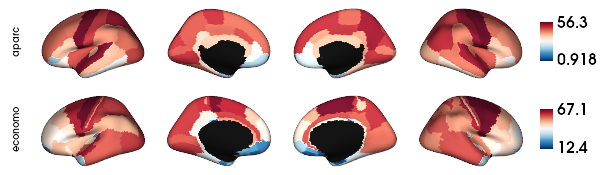

In [62]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[0:2], size=(600, 175), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[0:2]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

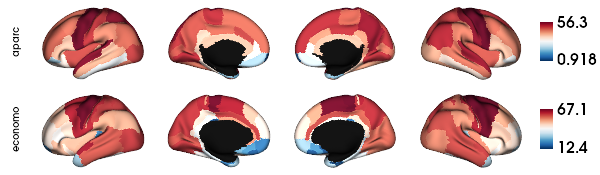

In [63]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[0:2], size=(600, 175), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[0:2]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

## Multimodal based parcellations 

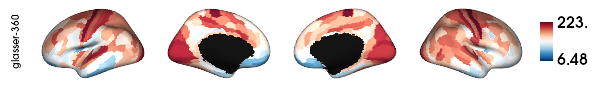

In [64]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[2], size=(600, 87), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':[parc[2]]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

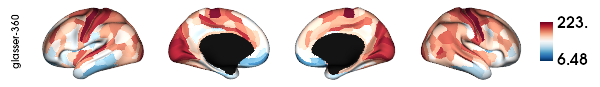

In [65]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[2], size=(600, 87), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':[parc[2]]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

## Functional based parcellations 

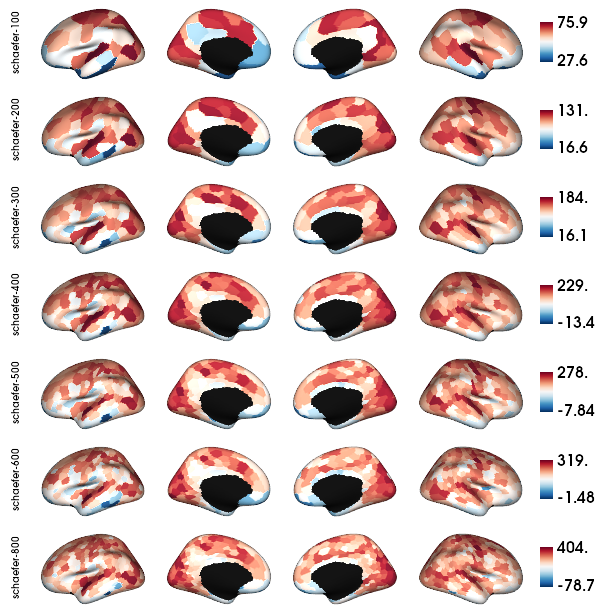

In [71]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[3:10], size=(600, 613), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[3:10]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

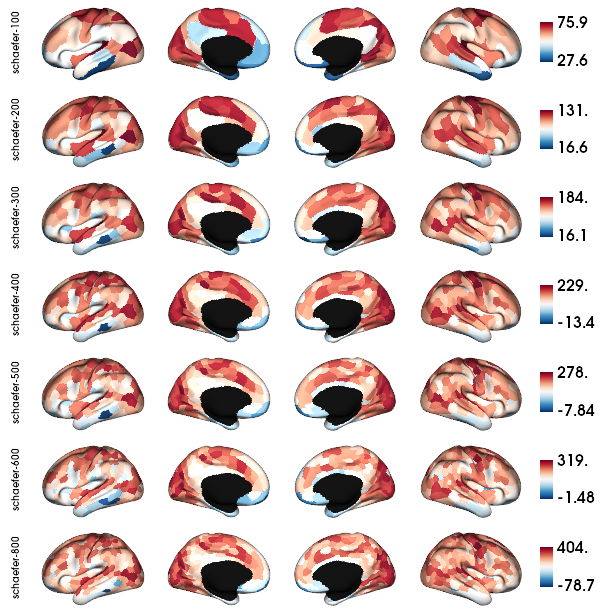

In [72]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[3:10], size=(600, 613), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[3:10]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

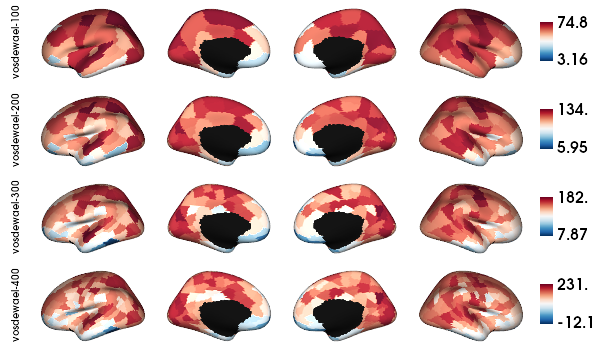

In [76]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[10:14], size=(600, 350), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[10:14]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

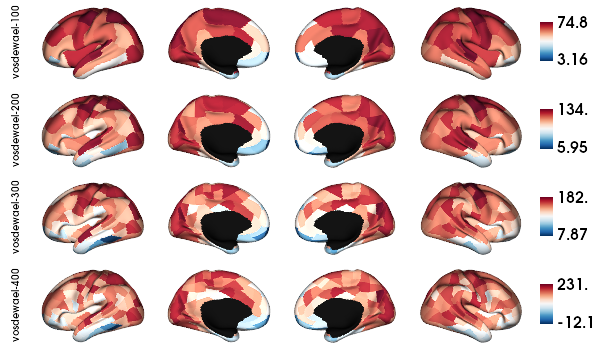

In [75]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[10:14], size=(600, 350), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[10:14]}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

In [108]:
def load_data(File, data_type):
    """
    Loads and processes a connectome data.

    Parameters:
        File (str): Path to the file.
        data_type (str): Type of the data. It can be 'GD', 'SC', 'FC', or 'MPC'.

    Returns:
        numpy.ndarray: Processed connectome data.
    """
    
    if data_type not in ['GD', 'SC', 'FC', 'MPC']:
        raise ValueError("Invalid data type. Please specify 'GD', 'SC', 'FC', or 'MPC'.")

    # Load the matrix
    data = nib.load(File).darrays[0].data
    
    if data_type != 'GD':
        # Mirror the matrix
        data = np.triu(data, 1) + data.T

    if data_type == 'FC':
        # Fisher transform
        data = np.arctanh(data)

    # Replace infinite values with epsilon
    data[~np.isfinite(data)] = np.finfo(float).eps
    
    # Replace 0 with epsilon
    data[data == 0] = np.finfo(float).eps
    
    return data

In [86]:
# Load fsLR-5k inflated surface
f5k_lh = read_surface(f'{micapipe}/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
f5k_rh = read_surface(f'{micapipe}/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# fsLR-5k mask
mask_lh = nib.load(f'{micapipe}/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_rh = nib.load(f'{micapipe}/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)


In [85]:
# Global variables
acq_func='se_task-rest_acq-AP_bold'
acq_mpc='T1map'
surf='fsLR-5k'
mod = ['GD', 'SC', 'FC', 'MPC']

# Path to fsLR-5k matrices: GD, SC, FC and MPC
f5k_files = [f'{subjectDir}/dist/{subjectID}_surf-{surf}_GD.shape.gii',
             f'{subjectDir}/dwi/connectomes/{subjectID}_surf-{surf}_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii',
             f'{subjectDir}/func/desc-{acq_func}/surf/{subjectID}_surf-{surf}_desc-FC.shape.gii',
             f'{subjectDir}/mpc/acq-{acq_mpc}/{subjectID}_surf-{surf}_desc-MPC.shape.gii']

# Load all the fsLR-5k matrices into a single array: {vertices x vertices x modality}
f5k_array = np.empty((9684, 9684, 4))

for i, f in enumerate(f5k_files):

    # Load the fsLR-32k connectome
    f5k_array[:,:,i] = load_data(f, mod[i])

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_11901/754883656.py:25: RuntimeWarning: divide by zero encountered in arctanh
  data = np.arctanh(data)


In [106]:
# Empty list of surface plots
surf_5k = [None] * len(mod)

for i, c in enumerate(mod):
    # If mod == SC, log the result for visualization
    if c == 'SC':
        mtx = np.log(f5k_array[:,:,i])
        mtx[~np.isfinite(mtx)] = 0
    else:
        mtx = f5k_array[:,:,i]
    
    # column mean
    c_mean = np.mean(mtx, axis=1)
    
    # mask the midwall
    c_mean[mask_5k==0] = np.nan
    
    # Add the new column mean array filled with NaN values in the midwall
    surf_5k[i] = c_mean
    

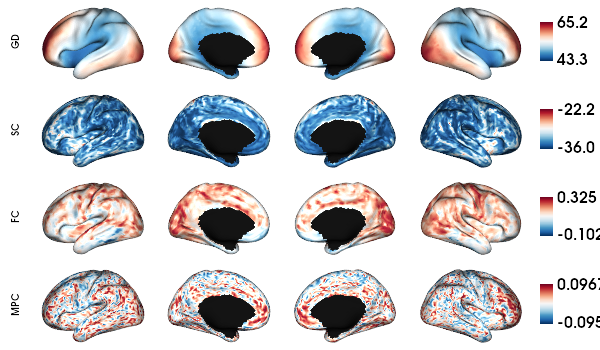

In [107]:
# Plot parcellations
plot_hemispheres(f5k_lh, f5k_rh, array_name=surf_5k, size=(600, 350), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':mod}, color_bar='right',
                 zoom=1.5, nan_color=(0, 0, 0, 1))

micapipe_v0.2.0/sub-HC001/ses-01/dist/sub-HC001_ses-01_surf-fsLR-5k_GD.shape.gii
micapipe_v0.2.0/sub-HC001/ses-01/dwi/connectomes/sub-HC001_ses-01_surf-fsLR-5k_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii
micapipe_v0.2.0/sub-HC001/ses-01/func/desc-se_task-rest_acq-AP_bold/surf/sub-HC001_ses-01_surf-fsLR-5k_desc-FC.shape.gii
micapipe_v0.2.0/sub-HC001/ses-01/mpc/acq-T1map/sub-HC001_ses-01_surf-fsLR-5k_desc-MPC.shape.gii


In [ ]:
parc = ['aparc-a2009s','schaefer-700','schaefer-900', 'schaefer-1000']